In [1]:
import logging
logging.getLogger('tensorflow').disabled = True
logging.getLogger('adanet').disabled = True

import functools
import os
import shutil
import time
import datetime

import tensorflow as tf
import adanet

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse

In [2]:
(x_train, y_train), (x_test, y_test) = (tf.keras.datasets.boston_housing.load_data())

head = tf.contrib.estimator.regression_head(loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)

model_dir = os.path.join(os.getcwd(),'basic_adanet_dnn_'+str(int(time.time())))

BATCH_SIZE = 32
RANDOM_SEED = 42
LEARNING_RATE = .001
TRAIN_STEPS = 60000
ADANET_ITERATIONS = 3
LAYER_SIZE = 64
ADANET_LAMBDA = .015
TRAINING_STEPS = 60
FEATURES_KEY = "x"

feature_columns = [tf.feature_column.numeric_column(key=FEATURES_KEY, shape=(x_train.shape[1],))]

In [3]:
def input_fn(partition, training, batch_size):

    def _input_fn():

        if partition == "train":
            dataset = tf.data.Dataset.from_tensor_slices(({
                FEATURES_KEY: tf.log1p(x_train)
            }, tf.log1p(y_train)))
            
            if training:
                dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()
                
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features, labels = iterator.get_next()
            return features, labels
            
        elif partition == "test":
            dataset = tf.data.Dataset.from_tensor_slices(({
                FEATURES_KEY: tf.log1p(x_test)
            }, tf.log1p(y_test)))
            
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features, labels = iterator.get_next()
            return features, labels
        
        else:
            dataset = tf.data.Dataset.from_tensor_slices({
                FEATURES_KEY: tf.log1p(x_test)
            })
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features = iterator.get_next()
            return features

    return _input_fn

In [4]:
estimator = adanet.AutoEnsembleEstimator(
    head=head,
    candidate_pool={"dnn2":
            tf.estimator.DNNEstimator(
                head=head,
                feature_columns=feature_columns,
                hidden_units=[LAYER_SIZE, LAYER_SIZE],
                model_dir=model_dir,
                optimizer=tf.train.ProximalAdagradOptimizer(
                    learning_rate=LEARNING_RATE,
                    l1_regularization_strength=0.001)),
                    "dnn3":
            tf.estimator.DNNEstimator(
                head=head,
                feature_columns=feature_columns,
                hidden_units=[LAYER_SIZE, LAYER_SIZE, LAYER_SIZE],
                model_dir=model_dir,
                optimizer=tf.train.ProximalAdagradOptimizer(
                    learning_rate=LEARNING_RATE,
                    l1_regularization_strength=0.001))
                   },
    max_iteration_steps=TRAIN_STEPS // ADANET_ITERATIONS,
    model_dir=model_dir,
    adanet_lambda=ADANET_LAMBDA)

W0705 15:28:39.856740 139840688838464 estimator.py:551] The following arguments have been moved to `adanet.ensemble.ComplexityRegularizedEnsembler` which can be specified in the `ensemblers` argument: ['adanet_lambda']


In [5]:
start_time = time.time()
estimator.train(input_fn=input_fn('train', training=True, batch_size=BATCH_SIZE), steps=TRAIN_STEPS)
print("Training completed in {}.".format(str(datetime.timedelta(seconds=time.time() - start_time))))

Training completed in 0:02:47.812325.


In [6]:
metrics = estimator.evaluate(input_fn=input_fn('train', training=False, batch_size=BATCH_SIZE), steps=None)

In [7]:
predictions = estimator.predict(input_fn=input_fn('pred', training=False, batch_size=y_test.shape[0]),
                                yield_single_examples=False)

predictions_list = list(predictions)
predictions_array = predictions_list[0]['predictions']

# convert original data to log scale.
y_test_log = tf.log1p(y_test)
with tf.Session() as sess:
    y_test_log = sess.run(y_test_log)
    
results = pd.DataFrame({'actual':y_test_log, 'hypothesis':np.squeeze(predictions_array)})

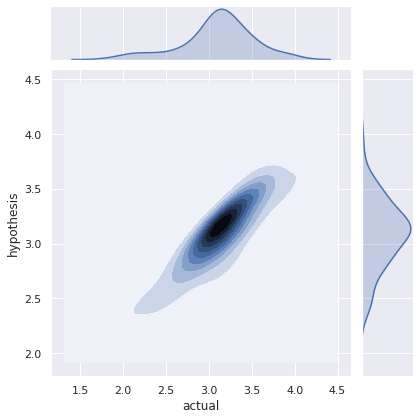

In [8]:
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(16,9)})
sns.jointplot(x="actual", y="hypothesis", data=results, kind="kde");

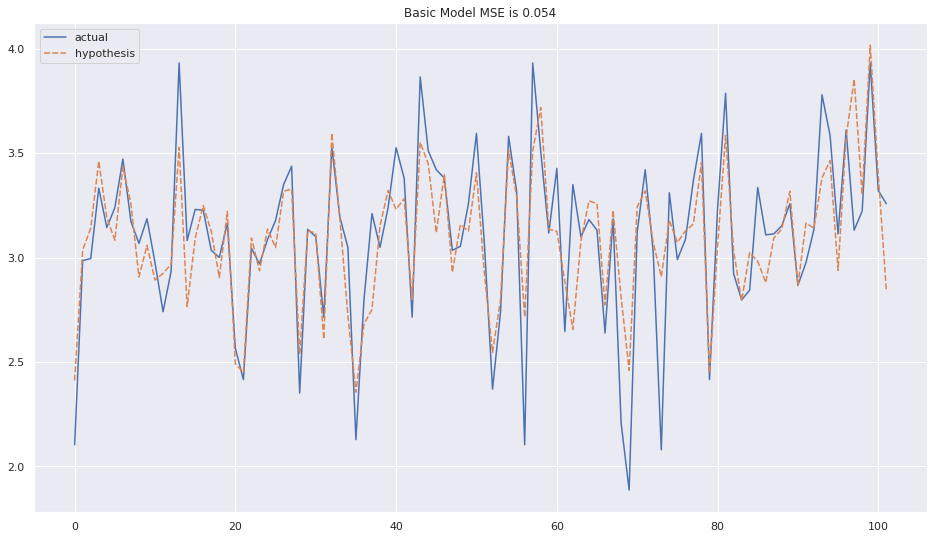

In [9]:
sns.lineplot(data=results).set_title('Basic Model MSE is {:,}'.format(round(mse(results.actual.values,
                                                                         results.hypothesis.values),3)));

___